## 0. Select Analysis

We have a user input here that can be modified to be either 'within' or 'across'. As you know the research design includes four time points T1 to T4 where T1 and T2 are pre and post intervention on the first session and T3 and T4 are pre and post intervention on the final session. 

Our 'within' analysis investigates whether there are any immediate effects of the intervention and thus compares the pre and post of the first session (T1 vs T2). Within refers to the analysis of data within a session.

Our 'across' analysis investigates whether there are any long-term effects of the intervention by comparing the first session to the final session (focusing on pre-intervention: T1 vs T3). Across refers to the analysis of data across sessions.

The remainder of this notebook will depend on this input, so to see each result would be to run the remainder twice.

In [ ]:
hypothesis = 2 #Can be 1 (t1 vs t2) or 2 (t1 vs T3)

if hypothesis == 1:
    fileName = 'autoRAFeaturesDataT1vsT2.csv'
elif hypothesis == 2:
    fileName = 'autoRAFeaturesDataT1vsT3.csv'
else:
    print('Analysis not supported. Please use hypothesis = 1 or hypothesis = 2.')
    
print(fileName)

# 1. Setup Environment and Load Data

We will begin by setting up our environment and loading our features dataset from the last script.

## 1.1. Import Modules

First, we must import the modules we will use in this tutorial.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from autora.skl.darts import DARTSRegressor, ValueType, DARTSExecutionMonitor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

## 1.2. Load Data
We will here load in the data of EEG features, we created in the last script.

In [3]:
featuresData = np.genfromtxt(fileName, delimiter=',')

print(featuresData.shape)

(95, 3)


## 1.3. Split Data Into Predictors and Outcomes

Although not a necessary step, I like to split my predictors from my outcomes explicitly for easier readability. We will use the first column as out outcomes, and the remaining columns as our predictors.

In [ ]:
outcomes = featuresData[:,0]
predictors = featuresData[:,1:]

print(outcomes.shape)
print(predictors.shape)

## 1.4 Normalize Predictors

Before we feed our data to the autonomous research assistant, we also need to normalize our predictors. Note that the predictors are *very* small. Without proper initialization or data normalization, machine learning algorithms have difficulty learning from the data because patterns more difficult to the detect (e.g. for small values). For this reason, we seek to normalize our predictors such that they have a mean of 0 and a standard deviation of 1.

In [5]:
# normalize predictors
print("Old Mean: " + str(np.mean(predictors)))
print("Old Standard Deviation: " + str(np.std(predictors)))

#scaler = StandardScaler()
#predictors = scaler.fit_transform(predictors)

print("New Mean: " + str(np.mean(predictors)))
print("New Standard Deviation: " + str(np.std(predictors)))

Old Mean: 0.01255089096521041
Old Standard Deviation: 0.14068570308882608
New Mean: 0.01255089096521041
New Standard Deviation: 0.14068570308882608


## 2.1. Split Data Into Train and Test

Machine learning relies on a train and test set and here we are going to use train_test_split from the scikit learn module to split data in this way. By default, this function uses 25% of the data as a test set, but this may be adjusted if preferred. Note that we are setting a seed (random_state = 1251) for reproducibility within the workshop.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(predictors, outcomes, random_state = 1251)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(71, 2)
(24, 2)
(71,)
(24,)


Note that we use upper case X to denote the predictors and lower case y to denote the outcomes. This is because X is a matrix (with rows corresponding to observations and columns corresponding to predictors) and y is a vector (with rows corresponding to observations).

# Differentiable Architecture Search (DARTS)

Now that we have our predictors and outcomes, we can use the autonomous research assistant to identify an interpretable model that can predict the outcomes.

## How it Works (you may skip this section)

Regular DARTS treats the architecture of a neural network as a directed acyclic computation graph (DAG), containing $N$ nodes in sequential order.

<img src="computation_graph.jpg" alt="Illustration of a Computation Graph" width="1000"></img>

Each node $x_i$ corresponds to a latent representation of the input space. Each directed edge $e_{i, j}$ is associated with some operation  $o_{i,j}$ that transforms the representation of the preceding node $i$, and feeds it to node $j$. Each intermediate node is computed by integrating over its transformed predecessors:

$x_j = \sum_{i<j} o_{i,j} \left( x_{i} \right).$

Every output node is computed by linearly combining all intermediate nodes projecting to it. The goal of DARTS is to identify all operations $o_{i,j}$ of the DAG. Following Liu et al. (2019), we define {$\mathscr{O} = \{o^1_{i,j}, o^2_{i,j}, \dots, o^M_{i,j}\}$} to be the set of $M$ candidate operations associated with edge $e_{i, j}$ where every operation $o^m_{i,j}(x_i)$ corresponds to some function applied to $x_{i}$ (e.g. linear,  exponential or logistic). DARTS relaxes the problem of searching over candidate operations by formulating the transformation associated with an edge as a mixture of all possible operations in $\mathscr{O}$ (cf. Figure A-B):

$\bar{o}_{i,j}(x) = \sum_{o \in \mathscr{O}} \frac{\textrm{exp}({\alpha^o_{i,j}})}{\sum_{o' \in \mathscr{O}} \textrm{exp}({\alpha^{o'}_{i,j}})} \cdot o_{i,j}(x).$

where each operation is weighted by the softmax transformation of its architectural weight $\alpha^o_{i,j}$. Every edge $e_{i, j}$ is assigned a weight vector $\alpha_{i,j}$ of dimension $M$, containing the weights of all possible candidate operations for that edge. The set of all architecture weight vectors $\alpha = \{\alpha_{i,j}\}$ determines the architecture of the model. Thus, searching the architecture amounts to identifying $\alpha$. The key contribution of DARTS is that searching $\alpha$ becomes amenable to gradient descent after relaxing the search space to become continuous. However, minimizing the loss function of the model $\mathscr{L}(w,\alpha)$ requires finding both $\alpha^*$ and $w^*$---the parameters of the computation graph.\footnote{This includes the parameters of each candidate operation $o^m_{i,j}$.} Liu et al. (2019) propose to learn $\alpha$ and $w$ simultaneously using bi-level optimization:<br><br>

$\min_\alpha \mathscr{L}_{\textrm{val}}\left(w^*(\alpha),\alpha\right) \\
\textrm{s.t. } w^*(\alpha) = \underset{w}{\operatorname{argmin}}   \mathscr{L}_{\textrm{train}}(w, \alpha).$

That is, one can obtain $\alpha^*$ through gradient descent, by iterating through the following steps:


- Obtain the optimal set of weights $w^*$ for the current architecture $\alpha$ by minimizing the training loss $\mathscr{L}_{\textrm{train}}(w, \alpha)$.
- Update the architecture $\alpha$ (cf. Figure C) by following the gradient of the validation loss $\nabla  \mathscr{L}_{\textrm{val}}\left(w^*,\alpha\right)$.


Once $\alpha^*$ is found, one can obtain the final architecture by replacing $\bar{o}_{i,j}$ with the operation that has the highest architectural weight, i.e. $o_{i,j}\leftarrow \textrm{argmax}_o \alpha^{*o}_{i,j}$ (Figure D).

## Defining the Search Space

DARTS is a machine learning algorithm that uses a search space of operations to find the best model. The search space is defined by the set of operations that can be applied in each computation step of the model. These operations are also referred to as *primitives*. We can select from the following space of primitives:

- **zero**: The output of the computation $x_j$ is not dependent on its input $x_i$.
- **add**: The output of the computation $x_j$ amounts to its input $x_i$.
- **subtract**: The output of the computation $x_j$ amounts to $-x_i$.
- **mult**: The output of the computation $x_j$ is its input $x_i$ multiplied by some constant $a$.
- **linear**: The output of the computation $x_j$ is linearly dependent on its input $x_i$: $x_j = a * x_i + b$.
- **relu**: The output of the computation $x_j$ is a rectified linear function of its input $x_i$: $x_j = \max(0, x_i)$.
- **exp**: The output of the computation $x_j$ is exponentially dependent on its input $x_i$: $x_j = exp(x_i)$.
- **logistic**: The output of the computation $x_j$ is a logistic function of its input $x_i$: $x_j = \frac{1}{1 + \exp(-b * x_i)}$.
- **sin**: The output of the computation $x_j$ is the sinus function of its input $x_i$: $x_j = sin(x_i)$.
- **cos**: The output of the computation $x_j$ is the cosinus function of its input $x_i$: $x_j = cos(x_i)$.
- **tanh**: The output of the computation $x_j$ is the tangens hyperbolicus of its input $x_i$: $x_j = tanh(x_i)$.

Some of the primitives above may also be preceded by a linear transformation, allowing for more degrees of freedom in the search space:

- **linear_relu**: The output of the computation $x_j$ is a rectified linear function of its *linearly transformed* input $x_i$: $x_j = \max(0, (a * x_i + b)$.
- **linear_exp**: The output of the computation $x_j$ is exponentially dependent on its *linearly transformed* input $x_i$: $x_j = \exp(a * x_i + b)$.
- **linear_logistic**: The output of the computation $x_j$ is a logistic function of its *linearly transformed* input $x_i$: $x_j = \frac{1}{1 + \exp(-b * (a * x_i + b))}$.
- **linear_sin**: The output of the computation $x_j$ the sinus function of its *linearly transformed* input $x_i$: $x_j = a * \sin(a * x_i + b)$.
- **linear_cos**: The output of the computation $x_j$ the cosinus function of its *linearly transformed* input $x_i$: $x_j = a * \cos(a * x_i + b)$.
- **linear_tanh**: The output of the computation $x_j$ the tangens hyperbolicus of its *linearly transformed* input $x_i$: $x_j = a * \tanh(a * x_i + b)$.


Let's begin with the following primitives:

In [7]:
PRIMITIVES = [
    "none",
    "add",
    "subtract",
    "logistic",
    "exp",
    "relu",
    "cos",
    "sin",
    "tanh",
]

## Set up the DARTS Regresssor

We will use the DARTS Regresssor to predict the outcomes. Meta-parameters are used to control the search space and the search algorithm. DARTS has quite a lot of those parameters. This section provides a basic overview of all parameters along with a description of their effects.

### General DARTS meta-parameters

- **`num_graph_nodes`**: The number of latent variables used to represent the model.
- **`max_epochs`**: The maximum number of epochs to run DARTS. This corresponds to the total number of architecture updates. These updates affect the architecture weights $\alpha$ indicating the relative contribution of each operation for a given computation step.
- **`output_type`**: The type of output to produce. We can choose between the following output types:
    - `ValueType.REAL` (default): The output is a real number.
    - `ValueType.PROBABILITY`: The output is a probability.
    - `ValueType.CLASS`: The output is a probability distribution over classes.

    In our case, we treat the outcome as a probability (e.g., the probability that the data comes from the first session T1 versus second session T2), so we will use **`ValueType.PROBABILITY`**.

### Meta-parameters for the architecture updates
The following parameters affect the updating of the architecture weights $\alpha$:

- **`arch_learning_rate_max`**: The initial (maximum) learning rate for updating the architecture updates. The higher the learning rate, the larger the steps taken to update the architecture weights. The learning rate decays with each epoch.
- **`arch_weight_decay`**: The weight decay for the architecture weights. The higher the weight decay, the more the high architecture weights are pressured to be small.
- **`arch_weight_decay_df`**: An additional weight decay that scales with the number of parameters (degrees of freedom) per operation. The higher this weight decay, the more DARTS will favor operations with few parameters.

### Meta-parameters for the parameter updates
The following parameters affect the updating of the parameters associated with each operation:

- **`param_updates_per_epoch`**: The number of steps taken by the parameter optimizer per epoch. Once the architecture updates are complete, the parameters associated with each operation are updated by a stochastic gradient descent over this number of steps.
- **`param_learning_rate_max`**: The initial (maximum) learning rate for updating the parameters. The higher the learning rate, the larger the steps taken to update the parameters. Note that the learning rate is scheduled to converge over the total number of parameter updates to **`learning_rate_min`**.
- **`param_learning_rate_min`**: The smallest possible learning rate for updating the parameters.
- **`param_momentum`**: The momentum for the architecture updates. The higher the momentum, the more the steps taken to update the architecture weights will be influenced by previous steps.
- **`param_weight_decay`**: The weight decay for the parameters. The higher the weight decay, the more the high parameters of each operation are pressured to be small.

### Meta-parameters for the classifier
The final output of the DARTS model is computed by concatenating all edges in the computation graph into a single vector and then adding a linear classifier. The linear classifier can attach a coefficient to each edge (weighing the contribution of that edge to the final output), and it can add a constant bias term. The following parameters affect the behavior of the classifier:

- **`train_classifier_coefficients`**: If set to `True`, the classifier coefficient of each edge will be trained (otherwise each coefficient is set to `1`, reflecting an equal contribution of each edge to the final output).
- **`train_classifier_bias`**: If set to `True`, the bias term of the classifier will be trained (otherwise the bias term is set to `0`).



Let's set up the DARTS regressor with some default parameters.

In [8]:
darts_estimator = DARTSRegressor(
        num_graph_nodes=1,
        param_updates_per_epoch=100,
        max_epochs=300,
        arch_updates_per_epoch=1,
        param_weight_decay=3e-4,
        arch_weight_decay_df=0.001,
        arch_weight_decay=1e-4,
        arch_learning_rate_max=0.3,
        param_learning_rate_max=0.0025,
        param_learning_rate_min=0.01,
        param_momentum=0.90,
        primitives=PRIMITIVES,
        train_classifier_bias=False,
        train_classifier_coefficients=False,
        output_type = ValueType.PROBABILITY
)

## Run the DARTS Regressor

Now we have everything to run differentiable architecture search (see Figure C). There are three steps to running DARTS:

1. Run the architecture search by fitting the mixture model.

2. Sample the final architecture weights and re-train the parameters of the model under the sampled architecture. In this case, we will sample each edge according to the *highest architecture weight*.

3. Print and visualize the model.

  0%|          | 0/300 [00:00<?, ?it/s]

Model:
k1 = + x1 - x2
y1 = 1.00 * k1 + 0.0


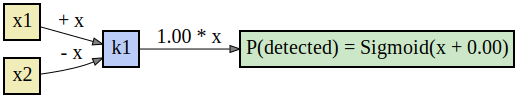

In [9]:
# train the architecture weights. By default, this will by default return the model with the highest architecture weights
darts_estimator.fit(X_train, y_train)

# re-fit the model with the fixed architecture weights
darts_estimator.set_params(
    max_epochs=0,  # no epochs of architecture fitting
    param_updates_for_sampled_model=1000,  # 1000 steps of param optimiziation
)
# print the model's formula
print(darts_estimator.model_repr())
# visualize the model
darts_estimator.visualize_model()

After running DARTS, we can also resample an architecture from the mixture model (see Figure D). If we select ``sampling_strategy="sample"`` then we can sample each operation with a propability that is proportional to it's final architecture weight.

In [ ]:
darts_estimator.set_params(
    max_epochs = 0, # make sure to not re-train architecture weights
    sampling_strategy="sample",  # overriding default "max"
    param_updates_for_sampled_model=800,
)
darts_estimator.fit(X_train, y_train)
print(darts_estimator.model_repr())
darts_estimator.visualize_model()

To recover the initial model, we need to return the sampling strategy to the default `"max"`:

0it [00:00, ?it/s]

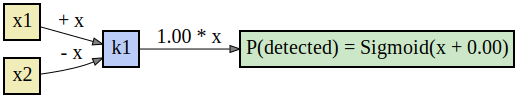

In [11]:
darts_estimator.set_params(
    max_epochs = 0, # make sure to not re-train architecture weights
    sampling_strategy="max",
    param_updates_for_sampled_model=1000,
)
darts_estimator.fit(X_train, y_train)
darts_estimator.visualize_model()

## Diagnosing DARTS: The execution monitor.

As you can see, there are lots of meta-parameters to choose from. To better understand what these parameters do, we want to have some more insight into the training dynamics of DARTS. We can obtain such insights from a so-called *execution monitor*. The monitor will provide us with two plots:

1) **Training Curve**: We this plots the loss of the DARTS algorithm as a function of training epochs. The lower the loss, the better the algorithm performs. Using this plot, you can evaluate how well DARTS converges on the training data.

2) **Architecture Weights**: Each edge in the computation graph is associated with an architecture weight. The monitor will display, for each edge, the trajectory of the corresponding architecture weights--each representing a different operation/primitive. Using this plot, you can evaluate which operations are preferred by DARTS over the course of training.

In [ ]:
# set up the execution monitor
execution_monitor_0 = DARTSExecutionMonitor()

# pass the monitor to the regressor
darts_estimator = DARTSRegressor(
        execution_monitor=execution_monitor_0.execution_monitor,
        # you may pass additional DARTS meta-parameters here, for now we will go with the defaults
)

# run DARTS
darts_estimator.fit(X_train, y_train)

# display the execution monitor
execution_monitor_0.display()
plt.show()


## Evaluate the Model

Finally, let us evaluate the sampled model by computing it's accuracy on the test set. In this case, we will round each estimate of the model $\hat{y} \in [0,1]$ to either 0 or 1, and compare against the ground truth.

In [ ]:
y_predicted = darts_estimator.predict(X_test)
accuracy = 1 - np.mean(np.abs(np.round(y_predicted.T)-y_test))

print('Accuracy: {:.4f}%'.format(accuracy*100))

# Exercise 1

Let us first gain some basic intuitions about DARTS. This is, perhaps, best accomplished by applying DARTS to a very simple test case (a unit test). In this test case we seek to recover a very simple function from synthetic data:

$$f(x) = e^x$$

The script below will generate synthetic data and then train a DARTS regressor to recover the function. You may want to run this script multiple times using different combinations of meta-parameters and primitives to see how the accuracy changes. For convenience, we pasted the meta-parameters below. You may also consult the documentation of AutoRA for further information: <a href="https://autoresearch.github.io/autora/">https://autoresearch.github.io/autora/</a>.

### General DARTS meta-parameters

- **`num_graph_nodes`**: The number of latent variables used to represent the model.
- **`max_epochs`**: The maximum number of epochs to run DARTS. This corresponds to the total number of architecture updates. These updates affect the architecture weights $\alpha$ indicating the relative contribution of each operation for a given computation step.
- **`output_type`**: The type of output to produce. We can choose between the following output types:
    - `ValueType.REAL` (default): The output is a real number.
    - `ValueType.PROBABILITY`: The output is a probability.
    - `ValueType.CLASS`: The output is a probability distribution over classes.

    In our case, we treat the outcome as a probability (e.g., the probability that the data comes from the first session T1 versus second session T2), so we will use **`ValueType.PROBABILITY`**.

### Meta-parameters for the architecture updates
The following parameters affect the updating of the architecture weights $\alpha$:

- **`arch_learning_rate_max`**: The initial (maximum) learning rate for updating the architecture updates. The higher the learning rate, the larger the steps taken to update the architecture weights. The learning rate decays with each epoch.
- **`arch_weight_decay`**: The weight decay for the architecture weights. The higher the weight decay, the more the high architecture weights are pressured to be small.
- **`arch_weight_decay_df`**: An additional weight decay that scales with the number of parameters (degrees of freedom) per operation. The higher this weight decay, the more DARTS will favor operations with few parameters.

### Meta-parameters for the parameter updates
The following parameters affect the updating of the parameters associated with each operation:

- **`param_updates_per_epoch`**: The number of steps taken by the parameter optimizer per epoch. Once the architecture updates are complete, the parameters associated with each operation are updated by a stochastic gradient descent over this number of steps.
- **`param_learning_rate_max`**: The initial (maximum) learning rate for updating the parameters. The higher the learning rate, the larger the steps taken to update the parameters. Note that the learning rate is scheduled to converge over the total number of parameter updates to **`learning_rate_min`**.
- **`param_learning_rate_min`**: The smallest possible learning rate for updating the parameters.
- **`param_momentum`**: The momentum for the architecture updates. The higher the momentum, the more the steps taken to update the architecture weights will be influenced by previous steps.
- **`param_weight_decay`**: The weight decay for the parameters. The higher the weight decay, the more the high parameters of each operation are pressured to be small.

### Meta-parameters for the classifier
The final output of the DARTS model is computed by concatenating all edges in the computation graph into a single vector and then adding a linear classifier. The linear classifier can attach a coefficient to each edge (weighing the contribution of that edge to the final output), and it can add a constant bias term. The following parameters affect the behavior of the classifier:

- **`train_classifier_coefficients`**: If set to `True`, the classifier coefficient of each edge will be trained (otherwise each coefficient is set to `1`, reflecting an equal contribution of each edge to the final output).
- **`train_classifier_bias`**: If set to `True`, the bias term of the classifier will be trained (otherwise the bias term is set to `0`).

In [ ]:
# generate the synthetic data: y = exp(x)
x = np.expand_dims(np.linspace(start=-1, stop=1, num=500), 1)
y = np.exp(x)

# define the primitives
primitives = [
    "none",
    "add",
    "subtract",
    "logistic",
    "exp",
    "relu",
    "cos",
    "sin",
    "tanh",
]

execution_monitor_0 = DARTSExecutionMonitor()

# train a DARTS regressor to recover the function
regressor = DARTSRegressor(
    execution_monitor=execution_monitor_0.execution_monitor,
    num_graph_nodes=1,
    param_updates_per_epoch=100,
    max_epochs=300,
    arch_updates_per_epoch=1,
    param_weight_decay=3e-4,
    arch_weight_decay_df=0.7,
    arch_weight_decay=1e-4,
    arch_learning_rate_max=0.01,
    param_learning_rate_max=0.0025,
    param_learning_rate_min=0.01,
    param_momentum=0.90,
    primitives=primitives,
    train_classifier_bias=False,
    train_classifier_coefficients=False,
    output_type=ValueType.REAL,
)

regressor.fit(x, y)
execution_monitor_0.display()

# resample the architecture parameters
regressor.set_params(
    sampling_strategy="max",
    param_updates_for_sampled_model=100,
)
regressor.fit(x, y)

# plot the ground truth against the model's prediction
y_predict = regressor.predict(x)

plt.figure()
plt.plot(x, y, "o")
plt.plot(x, y_predict, "-")
plt.legend(["grund truth", "model prediction"], loc=0)
plt.show()

# print the model
print(regressor.model_repr())

# visualize the model
regressor.visualize_model()

# Exercise 2

Now that you have gained some basic intuitions about DARTS, we encourage you to improve the accuracy of the symbolic model on the extracted EEG features by trying out different search parameters and modifying the search space.

For convenience, we have provided the following code to run and evaluate the search:

In [ ]:
# You may modify the search space below to improve the accuracy of the model.
# See section "Defining the Search Space" for more details.

import random

outcomes = featuresData[:,0]
predictors = featuresData[:,1:]

X_train, X_test, y_train, y_test = train_test_split(predictors, outcomes)

PRIMITIVES = [
    "none",
    "add",
    "subtract",
    "linear",
    "linear_logistic",
    "mult",
    "linear_relu",
    "relu",
    "exp",
    "logistic",
    "sin",
    "cos",
    "tanh",
    "linear_exp",
    "linear_sin",
    "linear_cos",
    "linear_tanh"
]

# You may modify the search parameters below to improve the accuracy of the model.

# General DARTS meta-parameters
num_graph_nodes = 2
max_epochs = 10
sampling_strategy = 'max' # 'max' or 'sample'

# Meta-parameters for the architecture updates
arch_updates_per_epoch=1
arch_learning_rate_max = .1
arch_weight_decay = .01
arch_weight_decay_df = .0001

# Meta-parameters for the parameter updates
param_updates_per_epoch = 500
param_learning_rate_max = 0.0025
param_learning_rate_min = 0.01
param_weight_decay = 3e-4
param_momentum = 0.90
param_updates_for_sampled_model = 1000

# Meta-parameters for the classifier
train_classifier_bias=True,
train_classifier_coefficients=True

# we will add this monitor to display the training performance
execution_monitor_0 = DARTSExecutionMonitor()

# run DARTS
darts_estimator = DARTSRegressor(
    execution_monitor = execution_monitor_0.execution_monitor,
    num_graph_nodes = num_graph_nodes,
    max_epochs = max_epochs,
    arch_updates_per_epoch = arch_updates_per_epoch,
    arch_learning_rate_max = arch_learning_rate_max,
    arch_weight_decay = arch_weight_decay,
    arch_weight_decay_df = arch_weight_decay_df,
    param_updates_per_epoch = param_updates_per_epoch,
    param_learning_rate_max = param_learning_rate_max,
    param_learning_rate_min = param_learning_rate_min,
    param_weight_decay = param_weight_decay,
    param_momentum = param_momentum,
    train_classifier_bias = train_classifier_bias,
    train_classifier_coefficients = train_classifier_coefficients,
    output_type=ValueType.PROBABILITY,
    primitives=PRIMITIVES,
)

darts_estimator.fit(X_train, y_train)

# display the execution monitor
execution_monitor_0.display()
plt.show()

# re-fit using the final architecture
darts_estimator.set_params(
    max_epochs = 0, # make sure to not re-train the architecture weights
    sampling_strategy = sampling_strategy,
    param_updates_for_sampled_model = param_updates_for_sampled_model,
)
darts_estimator.fit(X_train, y_train)

# evaluate the model
y_predicted = darts_estimator.predict(X_test)
accuracy = 1 - np.mean(np.abs(np.round(y_predicted.T)-y_test))

# print accuracy and visualize model
print('******************')
print('Accuracy: {0}%'.format(accuracy*100))
print('******************')
print(darts_estimator.model_repr())
darts_estimator.visualize_model()

# References

Liu, H., Simonyan, K., & Yang, Y. (2018). Darts: Differentiable architecture search. In *International Conference on Learning Representations*. arXiv: https://arxiv.org/abs/1806.09055

Musslick, S. (2021). Recovering quantitative models of human information processing with differentiable architecture search. In *Proceedings of the 43rd Annual Conference of the Cognitive Science Society* (pp. 348–354). Vienna, AT. arXiv: https://arxiv.org/abs/2103.13939